# Init

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc("figure", dpi=90)


# plat a function on a graph
def plot_function(f, title=None, min=-2.1, max=2.1, color="r", ylim=None):
    x = torch.linspace(min, max, 100)[:, None]
    if ylim:
        plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None:
        plt.title(title)


# Calc value  of a point on any quadratic
def quad(a, b, c, x):
    return a * x**2 + b * x + c


def mk_quad(a, b, c):
    return partial(quad, a, b, c)


# Add noise to a function
def noise(x, scale):
    return np.random.normal(scale=scale, size=x.shape)


def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)

# Fitting to a function

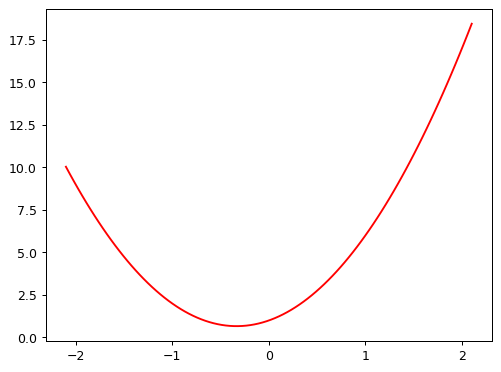

In [2]:
# Say you have a function that you want to fit to
# but you dont actually know the function
f = mk_quad(3, 2, 1)
plot_function(f)

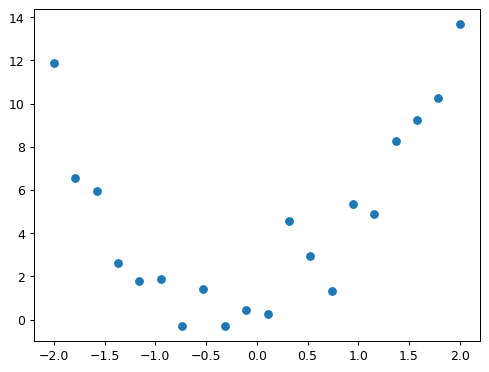

In [3]:
# In real life our data probably isnt perfect there is some noise
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:, None]
y = add_noise(f(x), 0.15, 1.5)
plt.scatter(x, y)

In [4]:
# We want to reconstruct the function from this noisy data
# you can play at doing it manually


# We can also calculate the mean absolute error (the distance from
# each point to the curve) to help
def mae(preds, acts):
    return (torch.abs(preds - acts)).mean()


@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    plt.scatter(x, y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3, 12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

You will find yourself wiggling each param from left to right and then iterating. Now we just need to automate this to 'learn'. We want to know how to wiggle them to get the changes we want so will calculate the derrivative.

# Gradient descent

In [5]:
# Takes our params as a single input and  returns the mae
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [6]:
# How would we use this
# 1. Pick some starting values and tell pytorch we want to calc the gradients
abc = torch.tensor([1.1, 1.1, 1.1])
abc.requires_grad_()

# 2. Work out the loss
loss = quad_mae(abc)

# 3. Work out the gradient. ie how to changing the params changes the loss
loss.backward()

print(f"loss={loss:.2f}")
abc.grad

loss=2.42


tensor([-1.3529, -0.0316, -0.5000])

In [7]:
# Lets tweak the parameters and see what happens to the loss. Lets do it in a loop


for i in range(5):
    loss = quad_mae(abc)
    loss.backward()

    with torch.no_grad():  # Dont calc grads for this bit, its not part of the quadratic
        abc -= abc.grad * 0.01

    print(f"loss={loss:.2f}")

loss=2.42
loss=2.38
loss=2.32
loss=2.23
loss=2.13


Run the above a bunch of times and the loss will keep trending towards 0. It eventuallly wont get any closer and might event go back up a bit (because our learing rate is fixed at 0.01 and we end up going to far).

# Using a neural network to approximate any function

The answer to whatever problem you are solving probling isnt represented as a quadratic. Its probably more complex. So how do we use a NN to approximate whatever that is.

In [8]:
# Turns out you can represent a infinitely flexible function from just this linear function


def rectified_linear(m, b, x):
    y = m * x + b
    return torch.clip(y, 0.0)


# It can also be written using pytorch
import torch.nn.functional as F


def rectified_linear2(m, b, x):
    return F.relu(m * x + b)


@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1, 4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [9]:
# It can also be written using pytorch
import torch.nn.functional as F


def rectified_linear2(m, b, x):
    return F.relu(m * x + b)


@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1, 4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [10]:
# What happens if we start summing them together?


def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)


@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), ylim=(-1, 6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

Now we get a slope with two components. We can add as many of these together as we want. We can use this to approximate any function with enough relus.

Now we can just start with random params into our relus and gradient descent until we fit our function.

# Matrix multiplication

We're going to be multipling lots of things together and adding them up. Matrix multiplication can help us do that but a lot quicker. A quick example:

In [23]:
# If we multiply a 3x3 matrix
a = np.array([[1, 2, 1], [7, 5, 3], [2, 3, 4]])

# by a 2x3 matrix
b = np.array([[2, 5], [6, 7], [1, 8]])

# For each row in the result
# Multiply row i by the first col and sum
# Multiply row i by the second column and sum
a.dot(b)

array([[15, 27],
       [47, 94],
       [26, 63]])

GPUs are really good a this (especially with multiplying 4x4 matricies).